# Introduction to TPOT

TPOT (Tree-based Pipeline Optimization Tool) is an open-source AutoML library in Python that uses genetic programming to automatically design and optimize machine learning pipelines. Instead of manually choosing models, preprocessing steps, and hyperparameters, TPOT searches through thousands of possible combinations, evolving better pipelines over time based on performance. It’s built on top of scikit-learn, so the generated pipelines are easy to export, understand, and integrate into existing workflows.

Diagram below shows how TPOT automates key steps in building a machine learning pipeline—selecting and constructing features, preprocessing data, choosing models, and tuning parameters—before the final model is validated.

For more detailed information check [official documentation](https://epistasislab.github.io/tpot/)

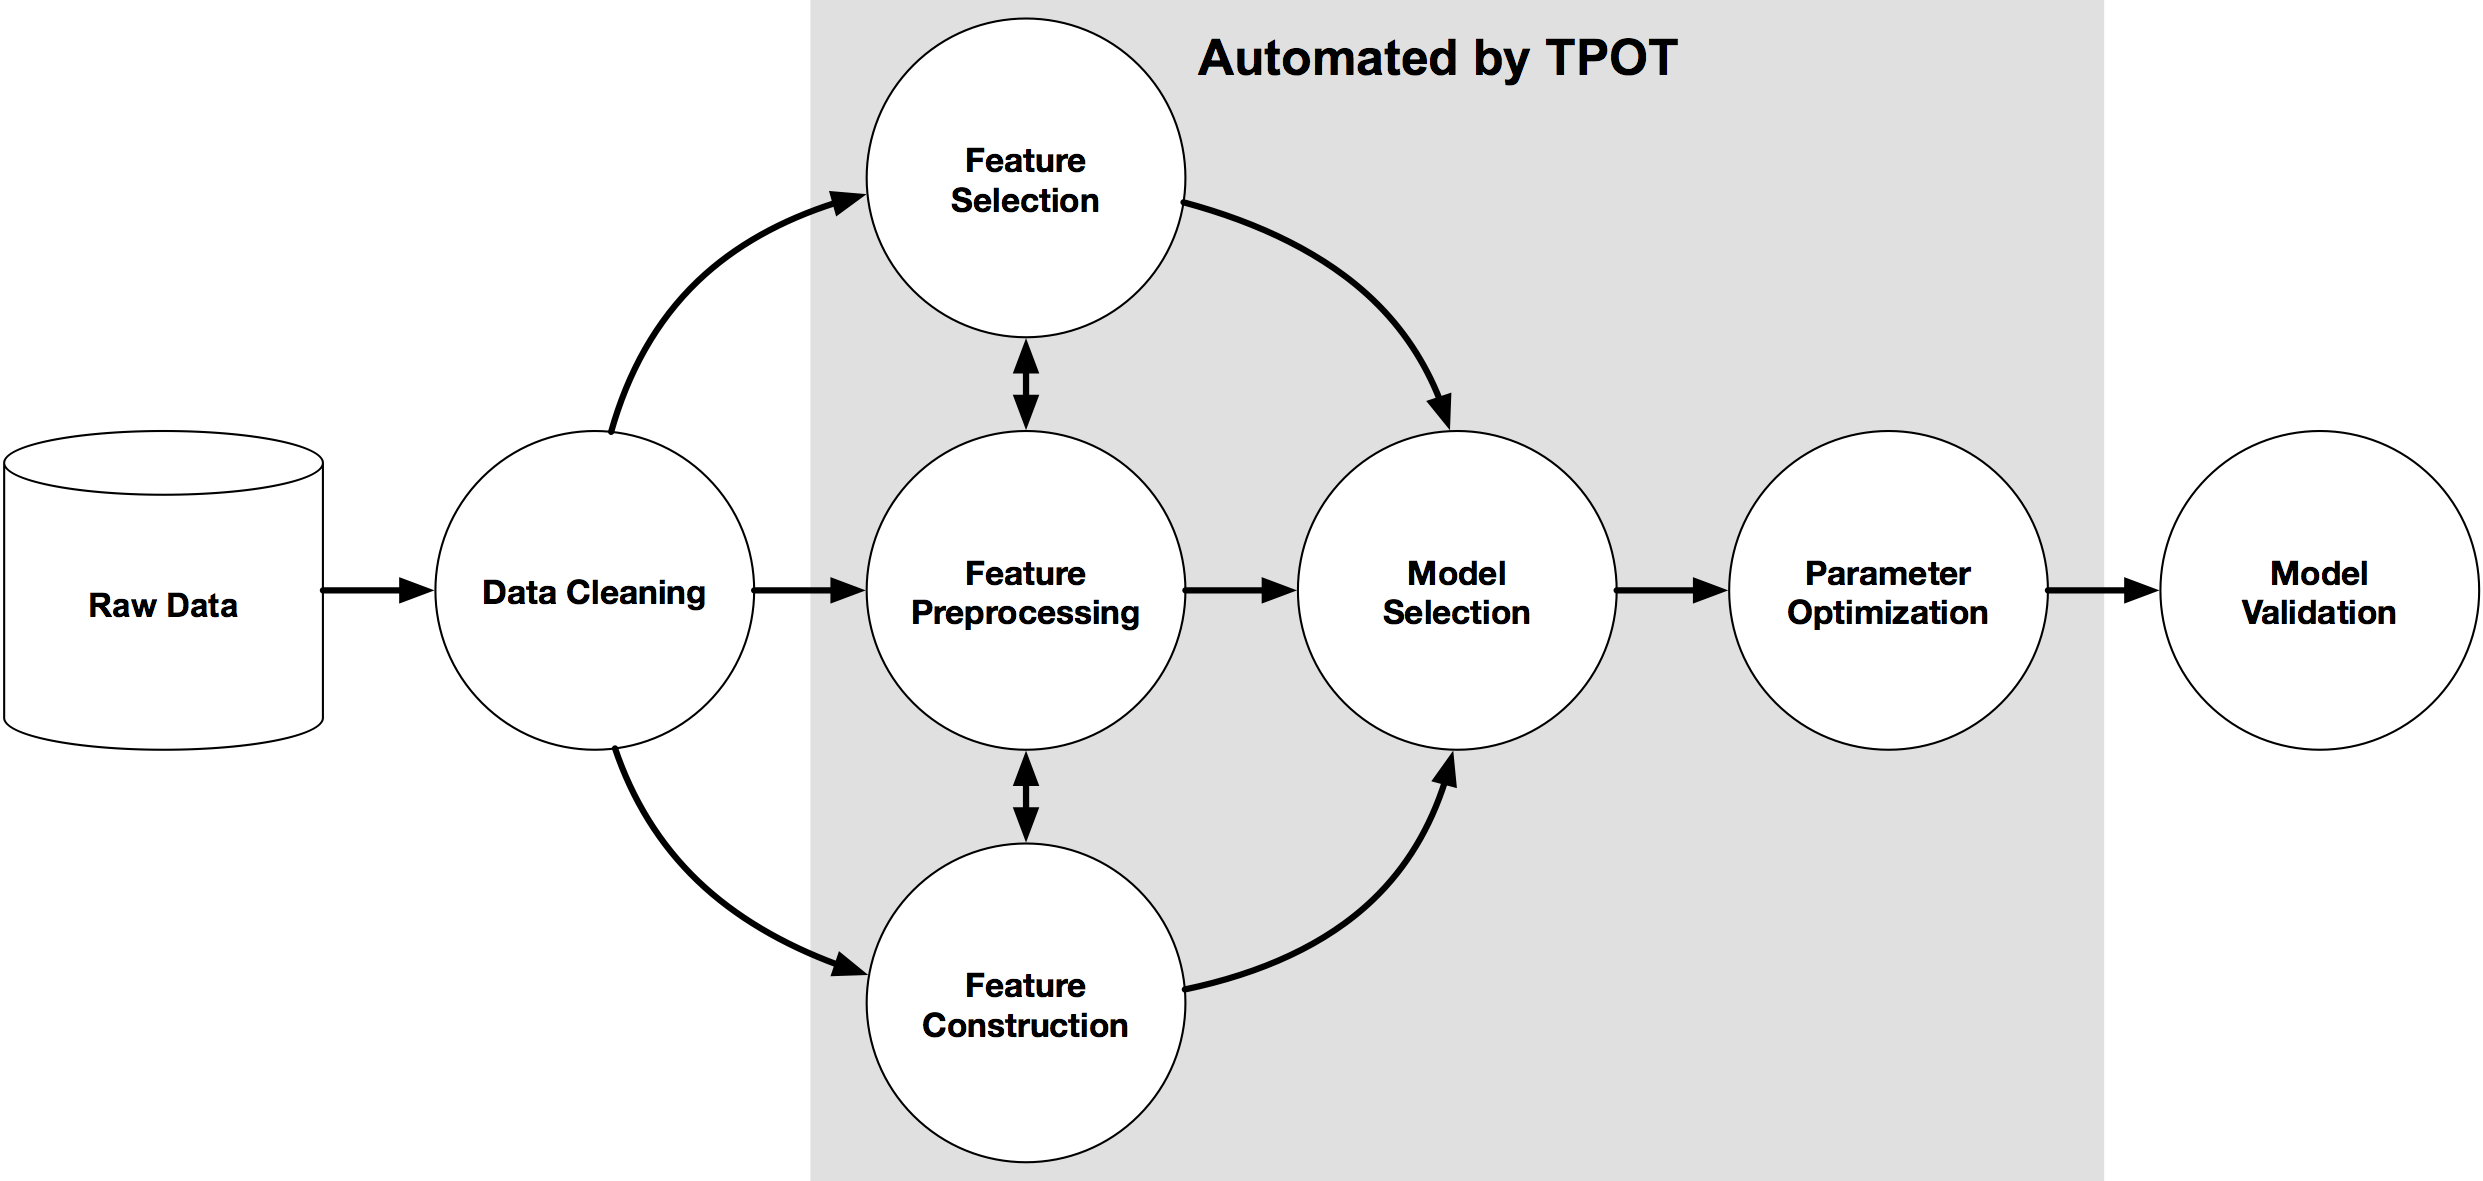

**Dataset used**  
In this practice session, we'll demonstrate TPOT's capabilities using the Titanic dataset.  

The Titanic dataset is a well-known dataset often used in machine learning tutorials. It contains passenger information such as age, gender, and other features related to survival.  

Download the dataset from the link below and unzip it:  
[Link to dataset](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv)


### 1. Install and import necessary modules

Below we import the necessary libraries containing the Python functions we need.  
We use **pandas** and **numpy** for data handling, helper utilities from **scikit-learn (sklearn)** for tasks like evaluation, **seaborn** for visualization, and **TPOT**,our main focus in this session.


In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings


### 2. Importing and Preparing Titanic dataset

We’ll import the CSV dataset and aim to predict whether passengers survived or not.  
To ensure valid labels, any rows with missing values (`NaN`) in the **Survived** column will be dropped.


In [2]:
# Load from .csv file
df = pd.read_csv('titanic.csv')

# Drop NAs from column that supposed to be predicted.
df = df.dropna(subset=['survived'])

Since TPOT is not designed for data cleaning, we need to handle that step ourselves.  

- First, we remove columns/features that have little to no impact on the outcome, such as whether a person was alive at the time of data collection or the city they embarked from.  
- Next, we fill in missing values(e.g replacing missing ages with the median age).  
- We then encode categorical features (such as *sex* or *alone*) into numerical form so they can be processed by machine learning models.  
- Finally, we separate the target column (*Survived*) from the rest of the dataset and split the rows into training and testing sets. The training set is used for model training, while the testing set is used to evaluate the performance of TPOT or the chosen classifiers.


In [3]:
## Remove columns that don't
df.drop(columns=['alive', 'who','embark_town', 'embarked'], inplace=True)

# Fill missing age values with the median
df['age'].fillna(df['age'].median(), inplace=True)

# Encode categorical columns
label_encoders = {}
for column in ['sex', 'class', 'deck', 'alone']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Define target and features
target_column = 'survived'
X = df.drop(columns=[target_column])
y = df[target_column]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Quick glance to edited features.

In [4]:
X_train

,pclass,sex,age,sibsp,parch,fare,class,adult_male,deck,alone
331,1,1,45.5,0,0,28.5000,0,True,2,1
733,2,1,23.0,0,0,13.0000,1,True,7,1
382,3,1,32.0,0,0,7.9250,2,True,7,1
704,3,1,26.0,1,0,7.8542,2,True,7,0
813,3,0,6.0,4,2,31.2750,2,False,7,0
...,...,...,...,...,...,...,...,...,...,...
106,3,0,21.0,0,0,7.6500,2,False,7,1
270,1,1,28.0,0,0,31.0000,0,True,7,1
860,3,1,41.0,2,0,14.1083,2,True,7,0
435,1,0,14.0,1,2,120.0000,0,False,1,0


 ### 4. Train the models

First, we'll train two traditional machine learning models without hyperparameter tuning. This will give us a baseline to compare against TPOT's performance in later stages.


- Random forest
- XGBoost

We'll set the random seed to **42** for all training processes in this lecture. This ensures that rerunning the code will produce the same results.  
When experimenting on your own, feel free to change or remove the random seed.


#### 4.1. Training Random Forest


In [5]:
### Train default Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf


RandomForestClassifier(random_state=42)

#### 4.2 Training XGBoost

In [6]:
## Also train default XGboost Classifier
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### 4.3. Fit the TPOT pipeline

Below we train TPOT. Let’s explain the key parameters used:  

- **scoring**: Most AutoML methods require an evaluation metric. For classification tasks this could be *accuracy* or *F1-score*, while for regression it could be *MSE* or *RMSE*.  
- **max_time_mins**: Since AutoML methods are optimization algorithms, they can theoretically run indefinitely. Setting a time limit ensures the process stops within a reasonable duration.  
- **verbosity**: Controls the amount of logging TPOT outputs. A higher value provides more detailed information during training. Useful for debugging for professionals and provide transparency for regular folks.
- **generations**: The number of evolutionary iterations (generations) TPOT will run. More generations generally improve performance but increase runtime.  
- **population_size**: The number of pipelines in each generation. A larger population increases search diversity but requires more computation.  
- **random_state**: Ensures reproducibility by fixing the random seed.  
- **n_jobs**: Number of CPU cores used. Setting it to `-1` tells TPOT to use all available cores.  

For whole list of parameters and attributes please check [API documentation](https://epistasislab.github.io/tpot/latest/tpot_api/classifier/)

In [7]:
# Use TPOT to find the best pipeline
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=40, random_state=42, n_jobs=-1,max_time_mins=2,scoring='accuracy')
tpot.fit(X_train, y_train)

# Evaluate the model
print(f"Test Accuracy: {tpot.score(X_test, y_test)}")



Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.


                                                                            
Generation 1 - Current best internal CV score: 0.8286417807544566
                                                                              
Generation 2 - Current best internal CV score: 0.8286417807544566
                                                                              
Generation 3 - Current best internal CV score: 0.83430513148823
                                                                              
Generation 4 - Current best internal CV score: 0.8398798384713878
                                                                              
Generation 5 - Current best internal CV score: 0.8398798384713878
                                                                              
Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=0.9000000000000001, verbosity=0)
Test Accuracy: 0.8100558659217877


##### List of evaluated models

TPOT keeps a log of every evaluated pipeline, which we can inspect later.  
For easier viewing and manipulation, we convert this log into a **pandas DataFrame**, which lets us sort, filter, and print results more comfortably.  


In [8]:
evaluated = tpot.evaluated_individuals_

evaluated = pd.DataFrame(evaluated).T
print('# of evaluated models: ',len(evaluated))
evaluated = evaluated.sort_values(by='internal_cv_score', ascending=False)
evaluated.tail(10)

# of evaluated models:  234


,generation,mutation_count,crossover_count,predecessor,operator_count,internal_cv_score
"XGBClassifier(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=7, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.05, XGBClassifier__verbosity=0)",0,0,0,"(ROOT,)",2,0.623599
"XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=8, XGBClassifier__min_child_weight=15, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.9500000000000001, XGBClassifier__verbosity=0)",0,0,0,"(ROOT,)",1,0.623599
"XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=5, XGBClassifier__min_child_weight=9, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.2, XGBClassifier__verbosity=0)",3,2,0,"(ExtraTreesClassifier(input_matrix, ExtraTrees...",1,0.623599
"XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=5, XGBClassifier__min_child_weight=8, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.9500000000000001, XGBClassifier__verbosity=0)",3,2,0,"(XGBClassifier(input_matrix, XGBClassifier__le...",1,0.623599
"GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.001, GradientBoostingClassifier__max_depth=7, GradientBoostingClassifier__max_features=0.9000000000000001, GradientBoostingClassifier__min_samples_leaf=11, GradientBoostingClassifier__min_samples_split=15, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)",5,2,0,"(GradientBoostingClassifier(input_matrix, Grad...",1,0.623599
"XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=8, XGBClassifier__min_child_weight=15, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.8500000000000001, XGBClassifier__verbosity=0)",1,1,0,"(XGBClassifier(input_matrix, XGBClassifier__le...",1,0.623599
"GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=1.0, GradientBoostingClassifier__max_depth=9, GradientBoostingClassifier__max_features=0.4, GradientBoostingClassifier__min_samples_leaf=10, GradientBoostingClassifier__min_samples_split=7, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.55)",1,1,0,"(MultinomialNB(input_matrix, MultinomialNB__al...",1,0.622289
"GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=1.0, GradientBoostingClassifier__max_depth=8, GradientBoostingClassifier__max_features=0.7000000000000001, GradientBoostingClassifier__min_samples_leaf=13, GradientBoostingClassifier__min_samples_split=17, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.7500000000000001)",0,0,0,"(ROOT,)",1,0.620752
"SGDClassifier(input_matrix, SGDClassifier__alpha=0.01, SGDClassifier__eta0=0.1, SGDClassifier__fit_intercept=True, SGDClassifier__l1_ratio=0.5, SGDClassifier__learning_rate=constant, SGDClassifier__loss=squared_hinge, SGDClassifier__penalty=elasticnet, SGDClassifier__power_t=100.0)",1,1,0,"(SGDClassifier(ZeroCount(input_matrix), SGDCla...",1,0.596582
"SGDClassifier(MLPClassifier(input_matrix, MLPClassifier__alpha=0.1, MLPClassifier__learning_rate_init=0.1), SGDClassifier__alpha=0.01, SGDClassifier__eta0=0.01, SGDClassifier__fit_intercept=False, SGDClassifier__l1_ratio=0.25, SGDClassifier__learning_rate=invscaling, SGDClassifier__loss=modified_huber, SGDClassifier__penalty=elasticnet, SGDClassifier__power_t=100.0)",4,2,0,(ExtraTreesClassifier(MLPClassifier(input_matr...,2,0.424288


#### Best model
Below we can see the best pipeline found by TPOT as a Python object.  
Note that the **XGBClassifier** shown here is not the same as the one we used in the baseline, we did not tune any hyperparameters, while TPOT automatically optimized them during the search process.


In [9]:
pipeline = tpot.fitted_pipeline_
pipeline

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100, n_jobs=1,
                               num_parallel_tree=None, random_state=42, ...))])

### 5. Evaluate on testing dataset

To make the comparison more realistic—similar to real-world scenarios—we evaluate performance on the **test set**, which was never used during training.


#### 5.1 TPOT prediction

In [10]:
### Evaluate on X test
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
accuracy_tpot = accuracy_score(y_test, y_pred)
print(f"Accuracy TPOT: {accuracy_tpot:.2f}")

Accuracy TPOT: 0.81


#### 5.2 Random forest prediction

In [11]:
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy RF: {accuracy_rf:.2f}")

Accuracy RF: 0.78


#### 5.3 XGBoost prediction

In [12]:
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy XGBoost: {accuracy_xgb:.2f}")

Accuracy XGBoost: 0.80


#### 6. Visualize TPOT vs RF vs XGBoost

Finally, we summarize and visualize the results.  
The accuracies of TPOT, Random Forest (default), and XGBoost (default) are collected into a DataFrame, and then displayed using a bar plot with **seaborn**.  
We set a title, adjust the y-axis for clearer comparison, and add labels above each bar to show exact accuracy values.  
This gives us a quick visual comparison of how TPOT performs against the baseline models.


/tmp/ipykernel_4974/2926415332.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=accuracies, palette=colors)


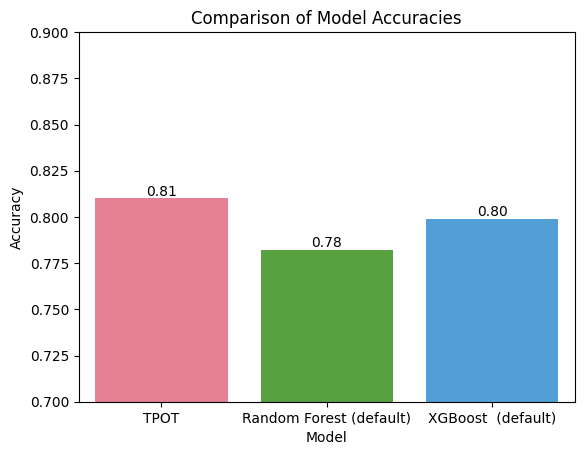

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

accuracies = pd.DataFrame({
    'Model': ['TPOT', 'Random Forest (default)', 'XGBoost  (default)'],
    'Accuracy': [accuracy_tpot, accuracy_rf, accuracy_xgb]
})

# Create a seaborn barplot
colors = sns.color_palette("husl", len(accuracies))
ax = sns.barplot(x='Model', y='Accuracy', data=accuracies, palette=colors)


# Set plot title and y-axis limit for more clear difference
plt.title('Comparison of Model Accuracies')
plt.ylim(0.7, 0.9)

# Add labels above each bar
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{p.get_height():.2f}',
        ha='center',
        va='bottom'
    )

# Show the plot
plt.show()

A model is considered better when it achieves higher accuracy, which we can clearly see in the graph above.  
With more time and computational resources allocated to TPOT, this performance gap could become even larger.
